In [1]:
#  Import dependencies
import math
from sklearn import datasets
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.metrics import accuracy_score, classification_report,r2_score,mean_absolute_error,mean_squared_error
from sklearn.dummy import DummyRegressor
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

In [2]:
# Skip this import should you run into issues (older sklearn versions)
from sklearn.metrics import mean_absolute_percentage_error

### Gets data from dataset

In [3]:
data = pd.read_csv('./data/pc_data (regression).csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15320 entries, 0 to 15319
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product ID        15320 non-null  int64  
 1   Brand             15320 non-null  object 
 2   Type              15320 non-null  object 
 3   Screen Size       15320 non-null  float64
 4   Screen Specs      15320 non-null  object 
 5   CPU               15320 non-null  object 
 6   RAM               15320 non-null  object 
 7   Hard Disk         15320 non-null  object 
 8   GPU               15320 non-null  object 
 9   Operating System  15320 non-null  object 
 10  Weight            15320 non-null  object 
 11  Price ($)         15320 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 1.4+ MB
None


No null values. As such, no imputation is required

### Data preprocessing

The extracted categorical values go through Python sklearn OneHotEncoder where each unique type of a given categorical input variable is assigned to a separate dummy numerical variable, with value of either zero or one, where one represents the selection of the type associated with the categorical input value. The Hard disk storage is also seperated into 4 numerical columns, each representing the storage capacity for a given type of drive in GB. CPU is also split into CPU clock speed (numerical) and CPU model (categorial). Screen resolution data is extracted from the Screen Specs column where the horizontal and vertical pixel counts are multiplied to derive the total number of pixels. After preprocessing, we represent the data as a Python numpy 2D array by stacking together the numerical and one-hot-encoded categorial variables using np.hstack. Lastly, Price will be used as the response variable.

In [3]:
columnInference = []
dataArr = np.array(data.iloc[:,1:])
# Handle Screen sizes
screenSize = np.array([dataArr[:,2]]).T
columnInference.append('Screen size')
# Converts screen resolutions to screen pixel counts
resolutions= np.array([i.split(' ')[-1].split('x') for i in dataArr[:,3]],dtype=int)
pixelCounts = np.array([resolutions[:,0]*resolutions[:,1]]).T
columnInference.append('Pixel Count')
# Handles Brand
enc = OneHotEncoder()
brandEnc=enc.fit_transform(dataArr[:,0].reshape(-1, 1)).toarray()
columnInference.extend(enc.categories_[0])
# Handles laptop type
enc = OneHotEncoder()
typeEnc=enc.fit_transform(dataArr[:,1].reshape(-1, 1)).toarray()
columnInference.extend(enc.categories_[0])
# Handle storage data
storage = [[j.split(' ',1) for j in i.split(' +  ')] for i in dataArr[:,6]]
storageTypes = ['SSD','HDD','Flash Storage','Hybrid']
storageEnc=np.zeros((len(storage),len(storageTypes)))
for n,i in enumerate(storage):
    for j in i:
        storageEnc[n][storageTypes.index(j[1])]+=float(j[0][:-2])*(lambda x: 1000 if (x=='TB')else (1 if (x=='GB') else 'err'))(j[0][-2:])
columnInference.extend(storageTypes)
# Handle RAM data
ram = np.array([[int(i[:-2]) for i in dataArr[:,5]]]).T
columnInference.append('Memory')
# Handle CPU spec data
enc = OneHotEncoder()
cpu,cpuSpeed=np.array([i.rsplit(' ',1)[0] for i in dataArr[:,4]]),np.array([float(i.rsplit(' ',1)[1][:-3]) for i in dataArr[:,4]]).reshape(-1,1)
cpuEnc = enc.fit_transform(cpu.reshape(-1, 1)).toarray()
columnInference.extend(enc.categories_[0])
columnInference.append('CPU Speed')
# Handle GPU spec data
enc = OneHotEncoder()
gpuEnc = enc.fit_transform(dataArr[:,7].reshape(-1, 1)).toarray()
columnInference.extend(enc.categories_[0])
# Handle OS type data
enc = OneHotEncoder()
osEnc = enc.fit_transform(dataArr[:,8].reshape(-1, 1)).toarray()
columnInference.extend(enc.categories_[0])
# Handle weight data
weight = np.array([[float(i[:-2]) for i in dataArr[:,9]]]).T
columnInference.append('Weight')
# Handle price data
price = list(map(float,dataArr[:,10]))

We can see from the data that larger screen sizes have a wider price range

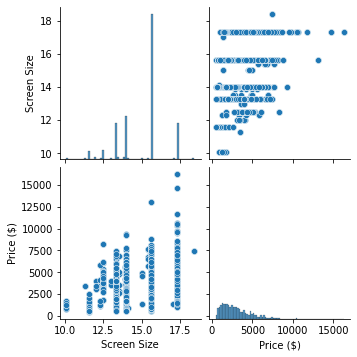

In [4]:
sns.pairplot(data.iloc[:,1:])
plt.show()

The code below assembles all the one-hod-encoded data and all the numerical data together

In [5]:
X,y = np.hstack((screenSize,pixelCounts,brandEnc,typeEnc,storageEnc,ram,cpuEnc,cpuSpeed,gpuEnc,osEnc,weight)),price

### Experiment

We then explore running the different models with many hyperparameter tunings with grid search. We use 5-fold cross validation for more reliable results. The purpose of this experiment is to find out which hyperparameter can be tuned and optimized to improve the model's accuracy score. We also want to find out how by changing the maximum depth/estimator count of some models, how the accuracy would hold up. This will be useful when performing inference or when there is limited computational power but high accuracy results are required. 

The data array then goes through the Python sklearn Train Test Split function to generate the Testing data, randomly selected 30% of the data, while the rest of the data is used for training and validation of the machine learning models

In [11]:
# Model comparison
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=21)
models = {    
    'RandomForest':RandomForestRegressor(n_jobs=-1),
    'GB':GradientBoostingRegressor(),
    'knn':KNeighborsRegressor(n_jobs=-1),
    'linreg':LinearRegression(),
    'tree':DecisionTreeRegressor(),
    'Ridge':Ridge(),
    'Lasso':Lasso(tol=1e-2),
    'svr':SVR(cache_size=100,max_iter=pow(10,7))
}
param_grid={
    'RandomForest':{ 
                'RandomForest__n_estimators' : np.arange(1,10,2),
                'RandomForest__max_depth': np.arange(1,50,10),
#                 'RandomForest__criterion':['squared_error','absolute_error']    # Newer sklearn versions
                'RandomForest__criterion':['mse','mae']    # Older sklearn versions
                   },
    'GB':{'GB__learning_rate': np.logspace(-4,1,10), 
                'GB__n_estimators' : np.arange(1,201,10),
#                 'GB__loss': ['squared_error','absolute_error']     # Newer sklearn versions
                'GB__loss': ['ls','lad']       # Older sklearn versions
         },
    
    'knn':{'knn__n_neighbors': np.arange(1,10,1), 
                'knn__leaf_size' : np.arange(10,100,10),
                'knn__p': [1,2],
                'knn__weights': ['uniform','distance'],
                'knn__metric': ['minkowski', 'chebyshev']},
    'linreg':{},
    'tree':{'tree__ccp_alpha':np.logspace(-3,5,100),
#             'tree__criterion':['squared_error','absolute_error','poisson']    # Newer sklearn versions
            'tree__criterion':['mse','mae','poisson']    # Older sklearn versions
           },
    'Ridge':{
        'Ridge__alpha':np.logspace(-5,1,20)
    },
    'Lasso':{
        'Lasso__alpha':np.logspace(-5,1,20)
    },
    'svr':{'svr__kernel':['rbf', 'sigmoid'],
           'svr__C':np.logspace(1,5,10),
          }
}
model_cv={}
normalize=[1,0,0,0,0,1,1,1]
# normalize = [0,1]
for n,modelName in enumerate(models):
    if normalize[n]==1:
        steps = [('StandardScaler',StandardScaler()),(modelName,models[modelName])]
    else:
        steps = [(modelName,models[modelName])]
    model = Pipeline(steps)
    model_cv[modelName]=(GridSearchCV(model, param_grid[modelName],cv=5,verbose=2,n_jobs=-1))
    model_cv[modelName].fit(X_train,y_train)
    y_pred = model_cv[modelName].predict(X_test)
    print(modelName)
    print(r2_score(y_test,y_pred))
    print(mean_squared_error(y_test,y_pred,squared=True))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 217 out of 250 | elapsed:  1.4min remaining:   12.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.7min finished


RandomForest
0.9981752036575438
6100.852660879286
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 853 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1298 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1825 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 10.6min finished
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:813: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:813: RuntimeWarning: overflow encountered in square
  array_stds = np.sqrt(np.average((array -


GB
0.9850937112429891
49836.28545892292
Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 853 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1298 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1825 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 2432 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 15.6min finished


knn
0.9985615244333824
4809.264071844896
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


linreg
0.8853310663261283
383373.3402724769
Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 853 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1298 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  5.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


tree
0.9985780717499944
4753.941328022345
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  43 out of 100 | elapsed:    7.2s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed:   15.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.1s finished


Ridge
0.8853467539740987
383320.8916640292
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of 100 | elapsed:   16.1s remaining:   21.3s
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed:   23.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.9s finished


Lasso
0.8853636252242794
383264.4859111447
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of 100 | elapsed:  2.7min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed:  4.0min remaining:   15.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


svr
0.9737297128147213
87829.61021318339


Here, we find the best parameters for each of the differnt models

In [12]:
for m in model_cv:
    print(model_cv[m].best_params_)
    

{'RandomForest__criterion': 'mse', 'RandomForest__max_depth': 31, 'RandomForest__n_estimators': 5}
{'GB__learning_rate': 0.7742636826811278, 'GB__loss': 'ls', 'GB__n_estimators': 191}
{'knn__leaf_size': 10, 'knn__metric': 'minkowski', 'knn__n_neighbors': 8, 'knn__p': 1, 'knn__weights': 'distance'}
{}
{'tree__ccp_alpha': 0.04132012400115339, 'tree__criterion': 'mse'}
{'Ridge__alpha': 20.6913808111479}
{'Lasso__alpha': 0.5455594781168515}
{'svr__C': 100000.0, 'svr__kernel': 'rbf'}


In [10]:
# Save models and results
model_cv
dumpFolder = open('./savedModels/regression_models','wb')
pickle.dump(model_cv,dumpFolder)
dumpResults = {}
for m in model_cv:
    dumpResults[m] = model_cv[m].cv_results_

dumpResultFolder = open('./savedModels/regression_model_results','wb')
pickle.dump(dumpResults,dumpResultFolder)
dumpBestParams = {}
for m in model_cv:
    dumpBestParams[m] = model_cv[m].best_params_

dumpBestParamsFolder = open('./savedModels/regression_best_params','wb')
pickle.dump(dumpBestParams,dumpBestParamsFolder)
dumpPred = {}
for m in model_cv:
    dumpPred[m] = model_cv[m].predict(X_test)
dumpPredFolder = open('./savedModels/regression_yPred','wb')
pickle.dump(dumpPred,dumpPredFolder)  

#### Lasso Coefficient for inference

The coefficients of the input variables are obtained and interpreted, which we use to understand how the computer brands and configurations could have positive/negative impacts on the PC prices as well as the significance of their impacts on the PC prices. For instance, looking at the coefficients of the different PC brands, we can analyze the impact of the Brand Name on the PC prices. For instance, we infer that Razer and LG tend to have high PC prices given the same product specifications. These brands may have overpriced their products compared to baseline brands such as Apple, Lenovo and MSI.


In [53]:
#Lasso
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=21)
steps = Pipeline([('StandardScaler',StandardScaler()),('Lasso',Lasso(tol=1e-2,alpha=0.5455594781168515))])
lassoExp = GridSearchCV(steps,{},cv=5,verbose=1,n_jobs=-1)
lassoExp.fit(X_train,y_train)
y_pred = lassoExp.predict(X_test)
print('Lasso Outcome')
print(f"r2 score: {r2_score(y_test,y_pred)}")
print(f"MSE: {mean_squared_error(y_test,y_pred,squared=True)}")
print('Lasso coefficients')
coeffsDf = pd.DataFrame([np.array(lassoExp.best_estimator_.named_steps['Lasso'].coef_)/np.array(lassoExp.best_estimator_.named_steps['StandardScaler'].scale_)],columns=columnInference)
for i in coeffsDf:
    print(f'{i}: {coeffsDf[i].iloc[0]}')
print('Latex script:')
print(coeffsDf.T.iloc[2:21].sort_values(0,ascending=False).round(1).to_latex(header=False)) #Latex to be copied into Technical paper


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Lasso Outcome
r2 score: 0.8853636252242794
MSE: 383264.48591114464
Lasso coefficients
Screen size: -34.39337145668571
Pixel Count: 0.0001243352220872459
Acer: -319.3667129075202
Apple: 0.0
Asus: -225.98143829333918
Chuwi: -653.7957567716172
Dell: -78.38094546774545
Fujitsu: -479.9107979678065
Google: 477.8645614219433
HP: 35.75431636971192
Huawei: -385.7795018891638
LG: 1018.5219473572056
Lenovo: 0.0
MSI: -0.0
Mediacom: -421.7234805906264
Microsoft: 225.56504521091068
Razer: 1368.3195897300718
Samsung: 386.1285940844343
Toshiba: 364.5977631716701
Vero: -464.2771456703452
Xiaomi: 222.68096811692104
2 in 1 Convertible: 304.1772690354075
Gaming: -444.7408334649344
Netbook: -3.0531729635735254
Notebook: -188.6240045293528
Ultrabook: 478.3664477408951
Workstation: 0.0
SSD: 2.2226891467552106
HDD: 0.1479632707460778
Flash Storage: 3.8329438184590625
Hybrid: 0.5945638570682235
Memory: 67.62663298575313
AMD A10-Series 9600P: -622.57015

/var/folders/k7/ndqk_8r17ydgb7r37f2gd1pr0000gt/T/ipykernel_24762/2140982241.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(coeffsDf.T.iloc[2:21].sort_values(0,ascending=False).round(1).to_latex(header=False))


### Tree Diagram

Shows the decision tree  structure of the model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tree Outcome:
r2 score: 0.9985780717499944
MSE: 4753.941328022347
Tree Diagram:


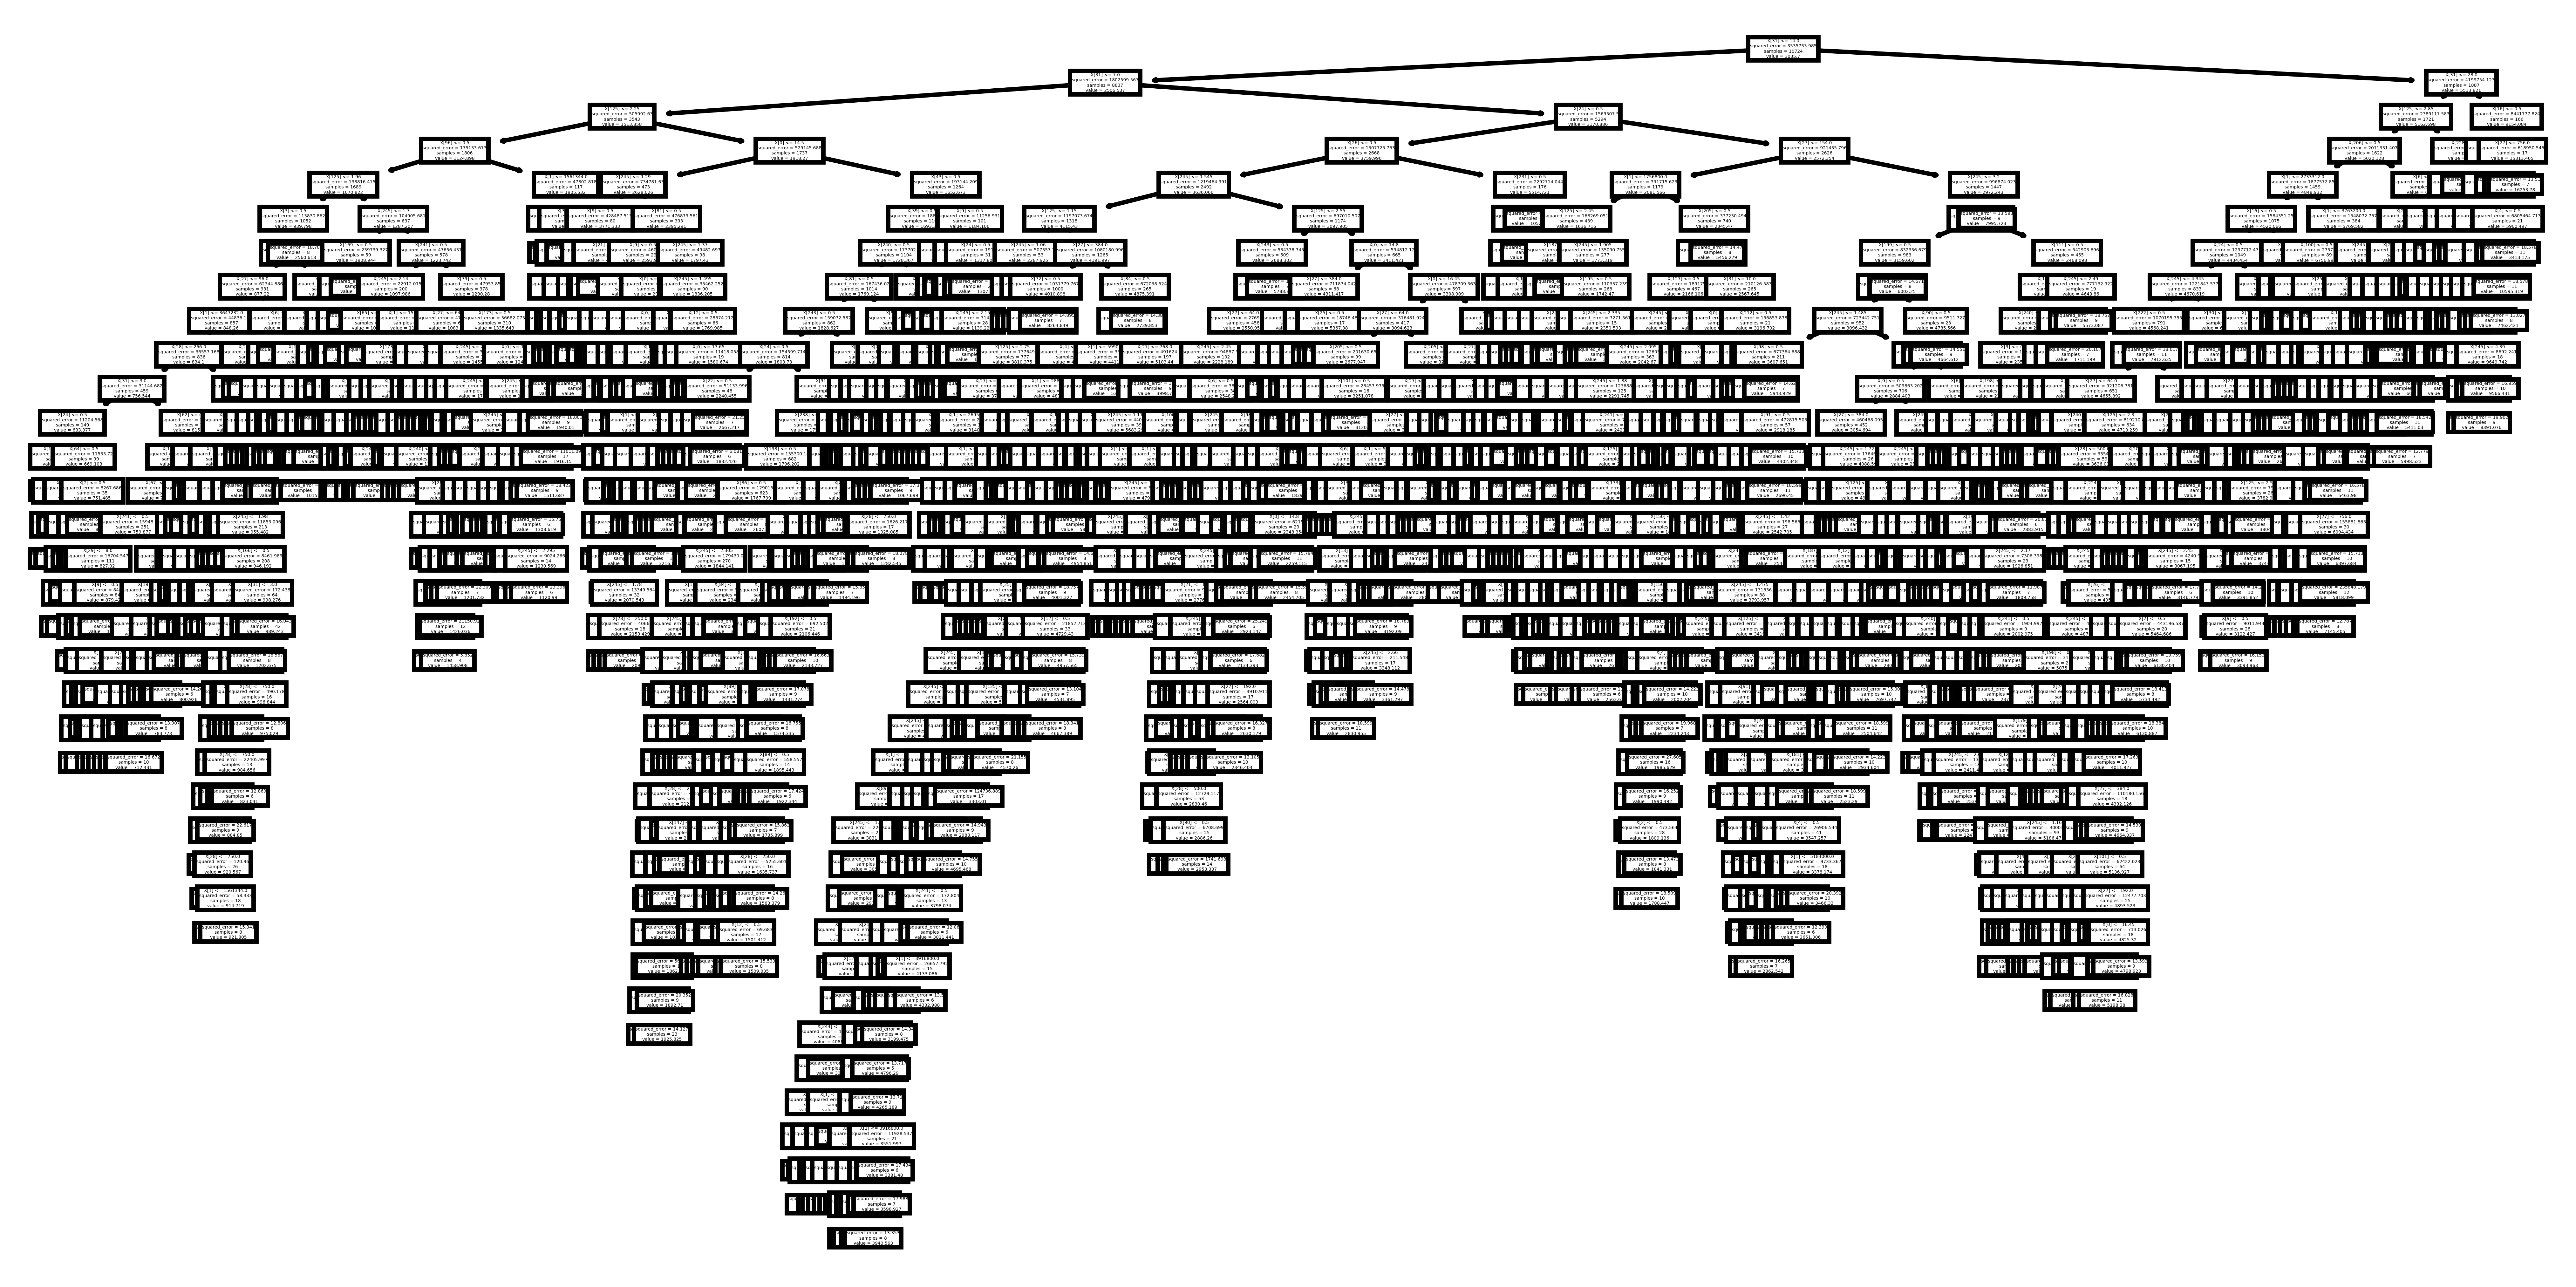

In [51]:
#Tree
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=21)
steps = Pipeline([('tree',DecisionTreeRegressor(ccp_alpha= 0.04132012400115339))]) 
treeExp = GridSearchCV(steps,{},cv=5,verbose=1,n_jobs=-1)
treeExp.fit(X_train,y_train)
y_pred = treeExp.predict(X_test)
print('Tree Outcome:')
print(f"r2 score: {r2_score(y_test,y_pred)}")
print(f"MSE: {mean_squared_error(y_test,y_pred,squared=True)}")
print('Tree Diagram:')
fig, ax = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5), dpi=1000)
tree.plot_tree(treeExp.best_estimator_.named_steps['tree'])
plt.show()


Since complex decision trees may be hard to interpret, I have included a smaller tree. In analysing the smaller tree below, we find that memory size, followed by GPU model, are one of the main factors influencing the price of the PC. We also find that higher end PCs have more than 14GB of RAM and use the Nvidia Geforce GTX 1080 (GTX 1080) Graphics card. In fact, back in 2017, the GTX 1080 was one of the best graphics card options for high performance gaming PCs. On the other hand, cheaper PCs tend to have less than 14GB of RAM and use the Intel HD Graphics 500. With less RAM installed, the manufacturer is able to cut the costs of the PC and lower its selling price. Furthermore, considering that the Intel HD Graphics 500 is integrated graphics, it means that the PC does not have an additional Discreet Graphics Processor which further decreases the price of the PC.

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tree Outcome:
r2 score: 0.5512990295739368
MSE: 1500144.6713107277
Tree Diagram:


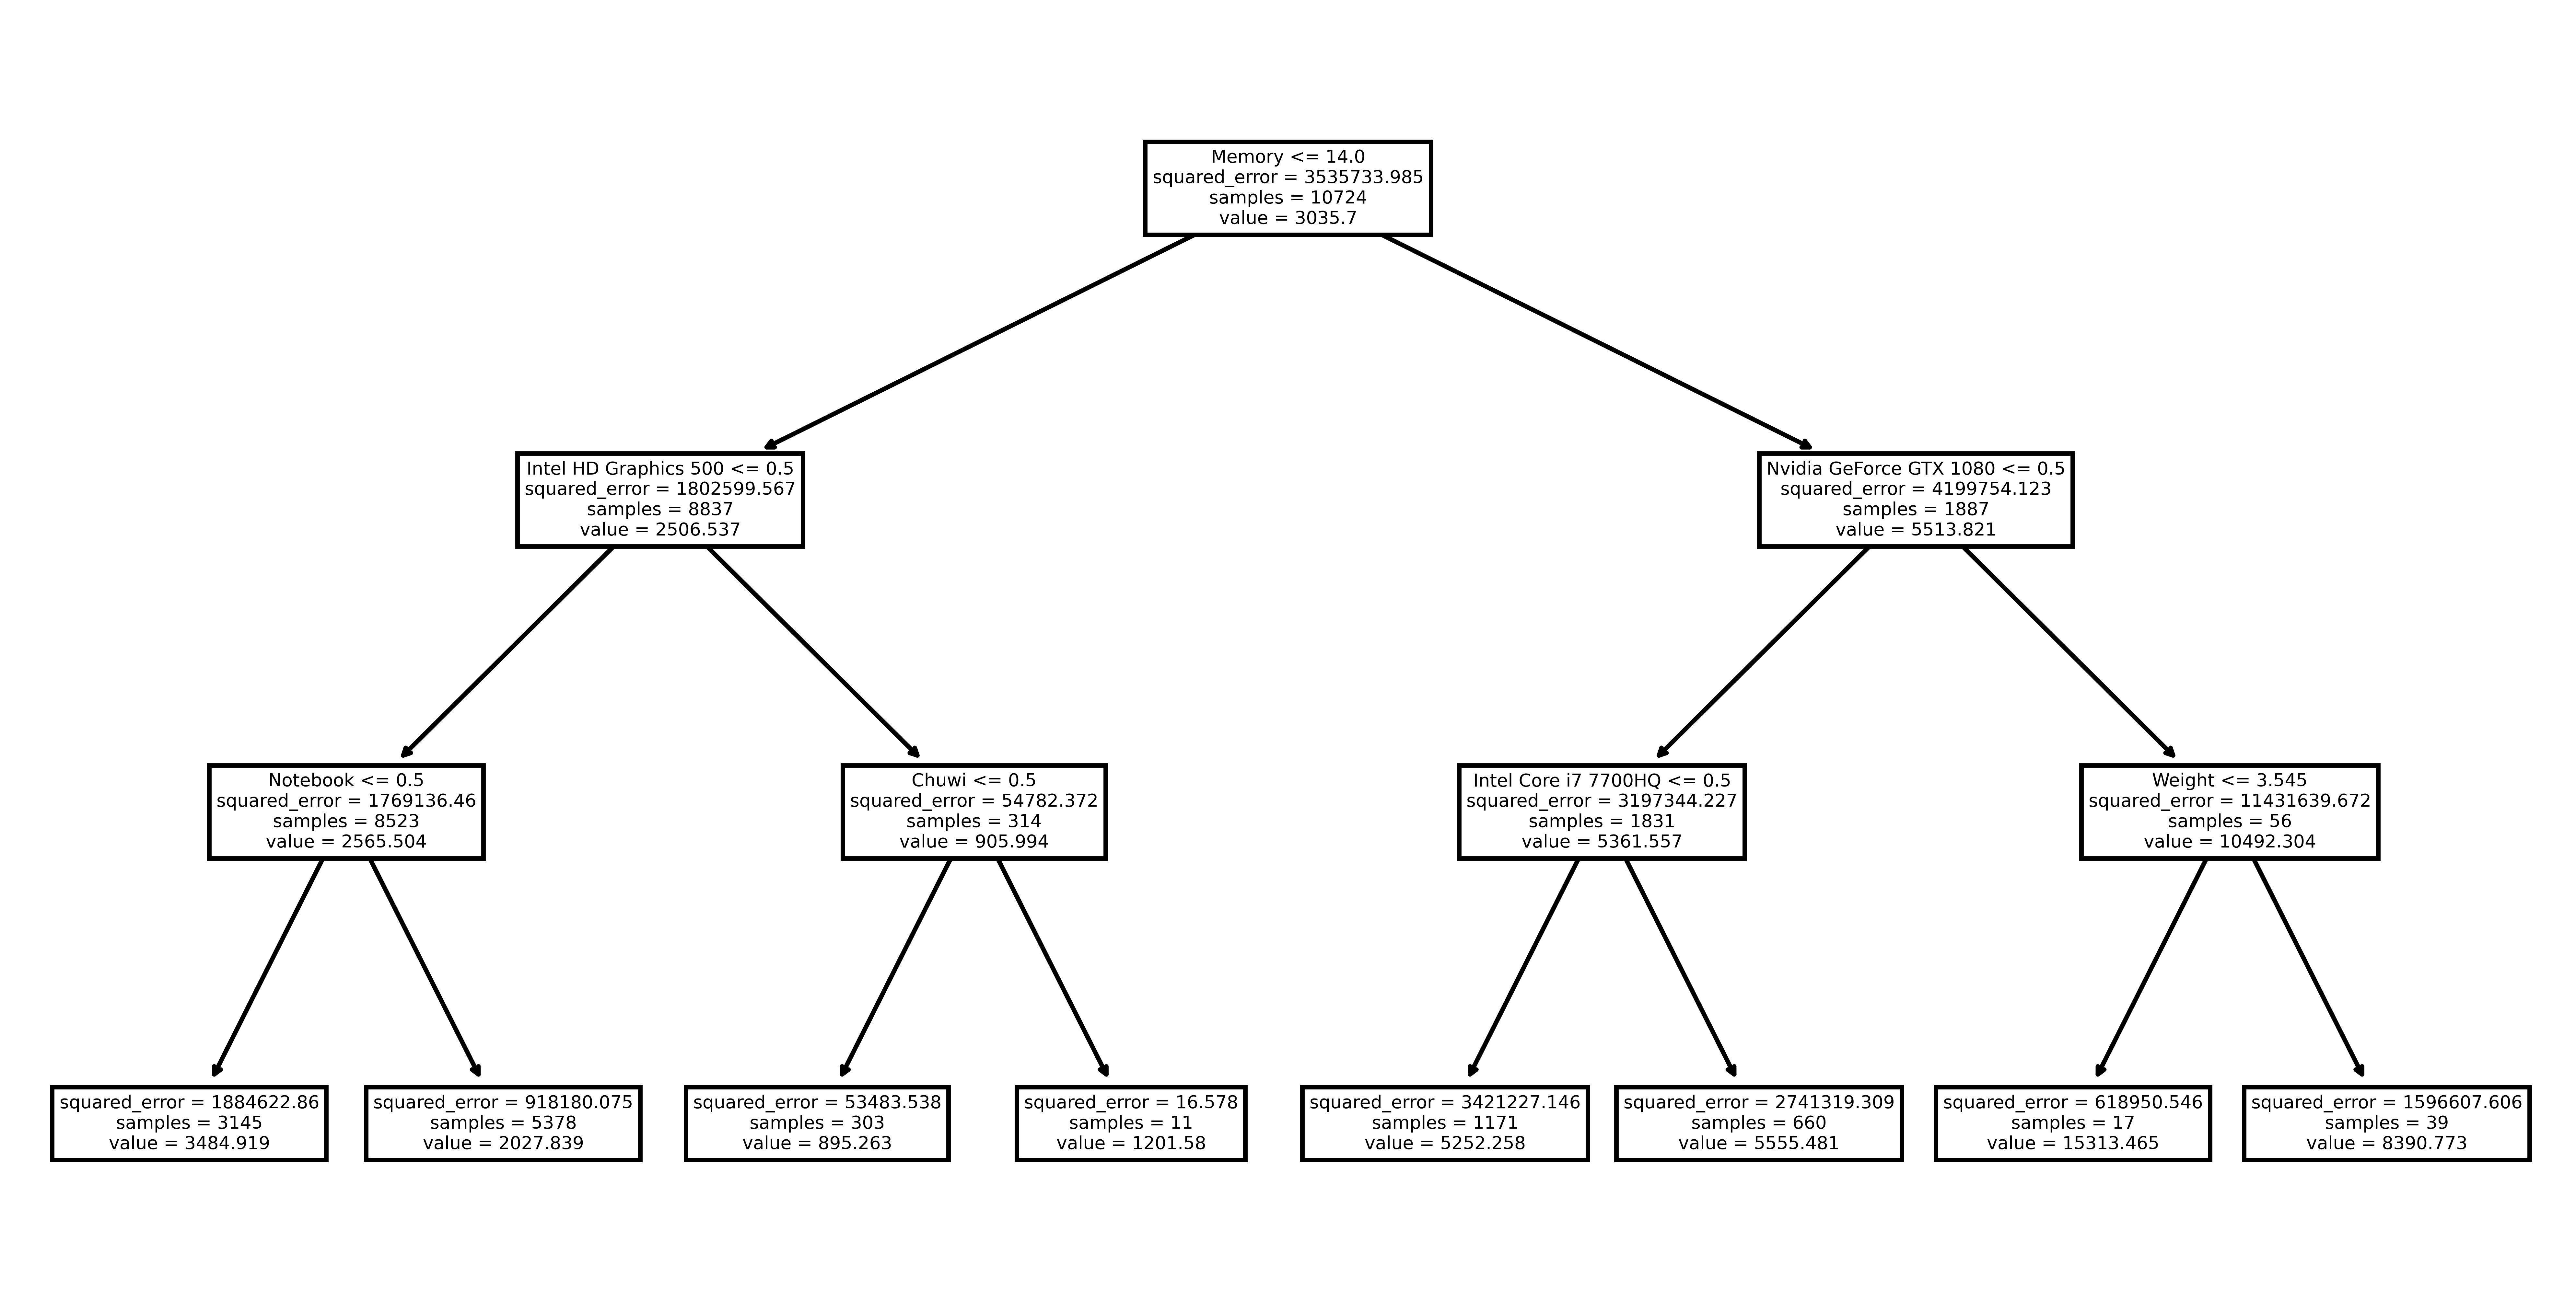

In [65]:
# Reduced Tree
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=21)
steps = Pipeline([('tree',DecisionTreeRegressor(ccp_alpha= 0.04132012400115339,max_depth=3,max_features=8))]) 
treeExp = GridSearchCV(steps,{'tree__random_state':[73]},cv=5,verbose=1,n_jobs=-1)
treeExp.fit(X_train,y_train)
y_pred = treeExp.predict(X_test)
print('Tree Outcome:')
print(f"r2 score: {r2_score(y_test,y_pred)}")
print(f"MSE: {mean_squared_error(y_test,y_pred,squared=True)}")
print('Tree Diagram:')

fig, ax = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5), dpi=1000)
tree.plot_tree(treeExp.best_estimator_.named_steps['tree'],feature_names=columnInference)
plt.show()

### Post Experiment Analysis

In [20]:
# Retrieve model results
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=21)
savedModelFolder = open('./savedModels/regression_model_results','rb')
model_cv_results=pickle.load(savedModelFolder)
bestParamsFolder = open('./savedModels/regression_best_params','rb')
model_bestParams=pickle.load(bestParamsFolder)
predFolder = open('./savedModels/regression_yPred','rb')
model_pred=pickle.load(predFolder)

Here, we compare all the models against the same testing data. We use Mean square error (MSE) as an indicator for model performance, which evaluates the average squared deviations between the predicted and true values. Hence, MSE more severely punishes models for producing outlier results and making it a better benchmark.

In [7]:
Outcomes = pd.DataFrame()
for m in model_cv_results:
    assembler = []
    results=pd.DataFrame(model_cv_results[m])[['params','mean_test_score']]
    assembler.append(m)
    assembler.append(r2_score(y_test,model_pred[m])) #r2 score
    assembler.append(mean_squared_error(y_test,model_pred[m],squared=True)) # Mean squared error
    assembler.append(mean_squared_error(y_test,model_pred[m],squared=False)) # Root mean squared error
    assembler.append(mean_absolute_error(y_test,model_pred[m])) # Mean absolute error
    assembler.append(mean_absolute_percentage_error(y_test,model_pred[m])) # Mean absolute percentage error
    Outcomes = pd.concat([Outcomes,pd.DataFrame(assembler).T],axis=0)
dummy = DummyRegressor(strategy='median')   # baseline model
dummy.fit(X_train,y_train)
dummyPred = dummy.predict(X_test)
assembler=[]
assembler.append('Dummy')
assembler.append(r2_score(y_test,dummyPred)) # r2 score
assembler.append(mean_squared_error(y_test,dummyPred)) # Mean squared error
assembler.append(mean_squared_error(y_test,dummyPred)) # Root mean squared error
assembler.append(mean_absolute_error(y_test,dummyPred)) # Mean absolute error
assembler.append(mean_absolute_percentage_error(y_test,dummyPred)) # Mean absolute percentage error
Outcomes = pd.concat([Outcomes,pd.DataFrame(assembler).T],axis=0)
Outcomes.set_axis(['Model','r2_Score','Mean Squared Error', 'RMS Error', 'Mean Absolute Error', '% Mean Absolute Error'],axis=1,inplace=True)
Outcomes.set_index('Model',inplace=True)
Outcomes


,r2_Score,Mean Squared Error,RMS Error,Mean Absolute Error,% Mean Absolute Error
Model,,,,,
RandomForest,0.998175,6100.852661,78.107955,21.510221,0.008017
GB,0.985094,49836.285459,223.240421,154.138586,0.065327
knn,0.998562,4809.264072,69.348858,18.306743,0.007101
linreg,0.885331,383373.340272,619.171495,432.141416,0.168568
tree,0.998578,4753.941328,68.948831,18.446395,0.007126
Ridge,0.885347,383320.891664,619.12914,431.923648,0.168382
Lasso,0.885364,383264.485911,619.083586,432.300473,0.168313
svr,0.97373,87829.610213,296.360608,106.426866,0.036854
Dummy,-0.03097,3446849.192673,3446849.192673,1373.209377,0.627274


Decision Tree has the lowest Mean Square error

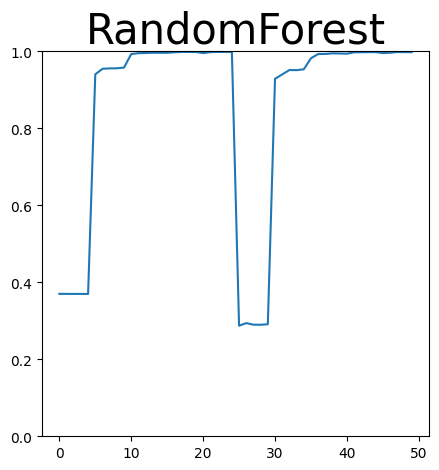

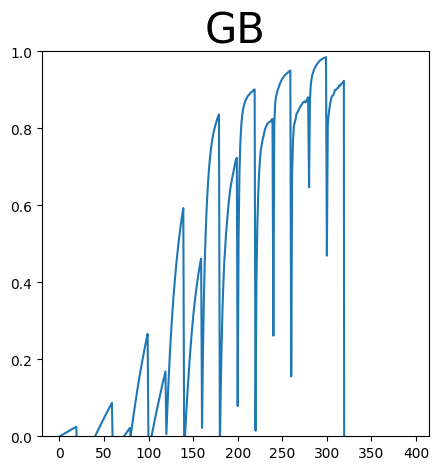

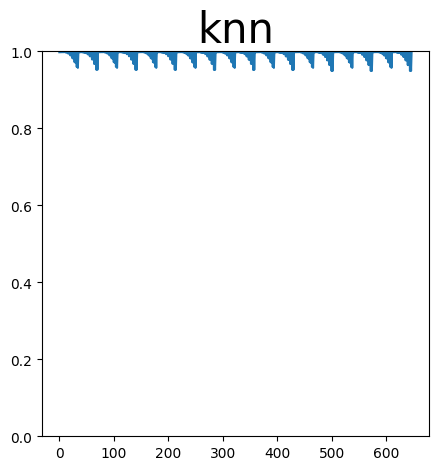

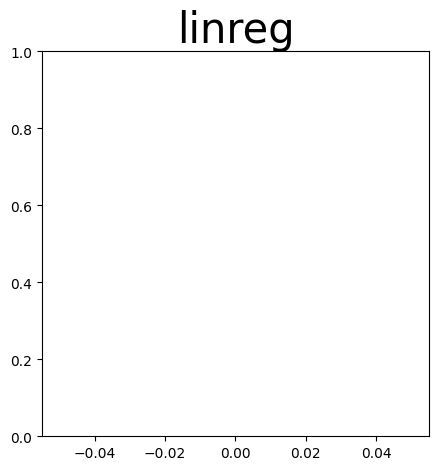

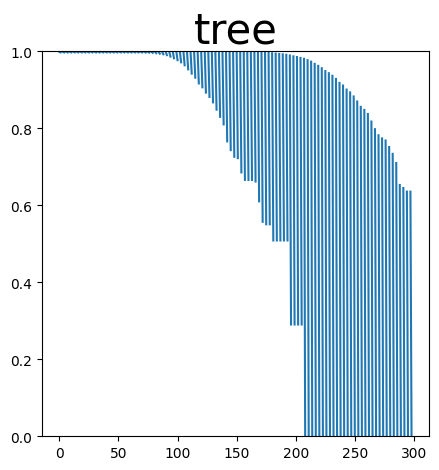

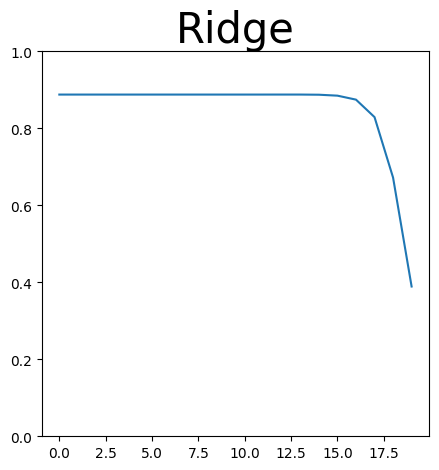

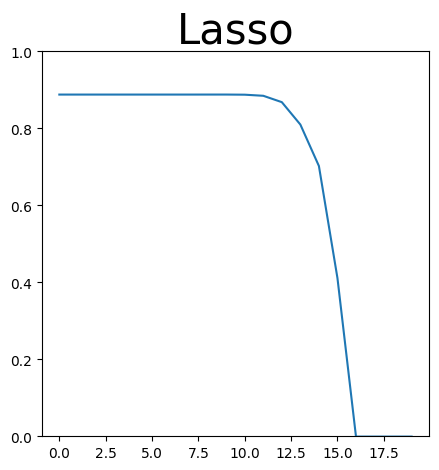

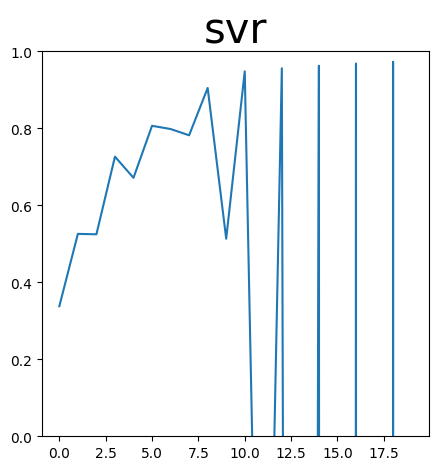

In [8]:
# Plots Grid Search Iterations
for m in model_cv_results:
    results=pd.DataFrame(model_cv_results[m])[['params','mean_test_score']]
    plt.figure(figsize=(5,5))
    plt.title(m,fontsize=30)
    plt.plot(np.arange(0,len(results['mean_test_score'])),results['mean_test_score'])
    plt.ylim(0,1)
    plt.show()

In [9]:
# Transform Dataframe
experiment_results = {}
for m in model_cv_results:
    objAssembler = {}
    for paramObj in model_cv_results[m]['params']:
        for j in paramObj:
            try:
                objAssembler[j].append(paramObj[j])
            except KeyError:
                objAssembler[j]=[]
                objAssembler[j].append(paramObj[j])
    experiment_results[m]=pd.concat([pd.DataFrame(objAssembler),pd.DataFrame(model_cv_results[m]['mean_test_score'])],axis=1)

### Lasso & Ridge Hyperparameter tuning

Here we show how adjusting the alpha penalty coefficient affects the Ridge and LASSO models. The x-axis are in lograrthmic scale.

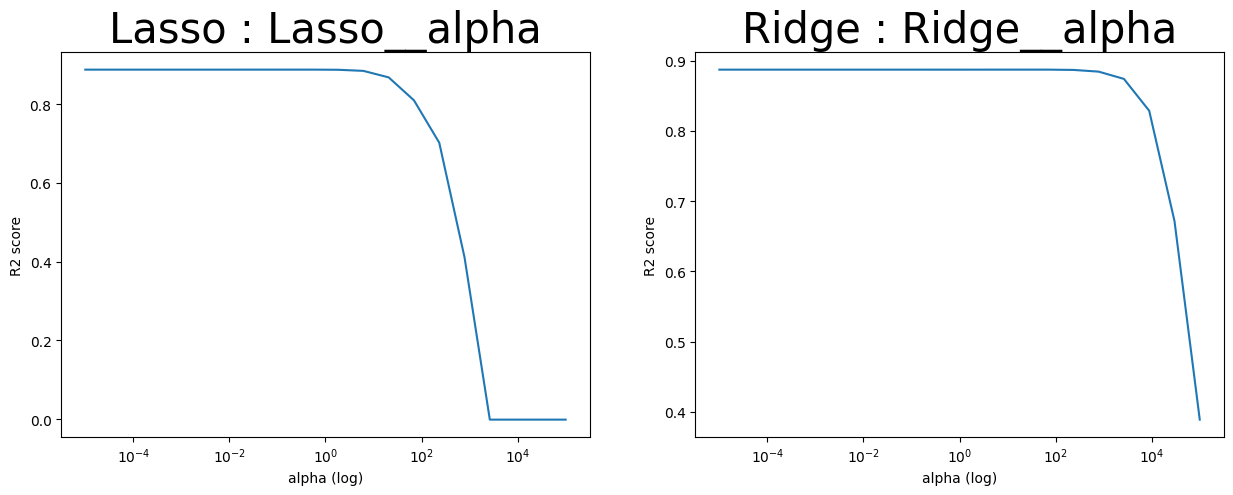

In [40]:
modelAnalyse = ['Lasso','Ridge']
plt.figure(figsize=(15,5))
for n,m in enumerate(modelAnalyse):
    results=pd.DataFrame(model_cv_results[m])[['params','mean_test_score']]
    for p in model_bestParams[m]:
        params = list(model_bestParams[m].keys())
        params.remove(p)
        plt.subplot(1,2,n+1)
        plt.title(f"{m} : {p}",fontsize=30)
        plt.xscale("log")
        plt.xlabel('alpha (log)')
        plt.ylabel('R2 score')
        plt.plot(np.logspace(-5,5,20),results['mean_test_score'])  #Plots against validation data

plt.show()

# Hyperparameter evaluation

Here, we look at how tuning the hyperparameter would affect the model. In the code below, each model will cycle through all of its hyperparameters. When it is plotting a certain hyperparameter, all other hyperparameter a set to the best value (obtained from .best_params_). The results are then plotted on a linegraph with the y axis representing the validation accuracy and the x axis representing the hyperparameter value and the plot title showing the model and the hyperparameter being compared.

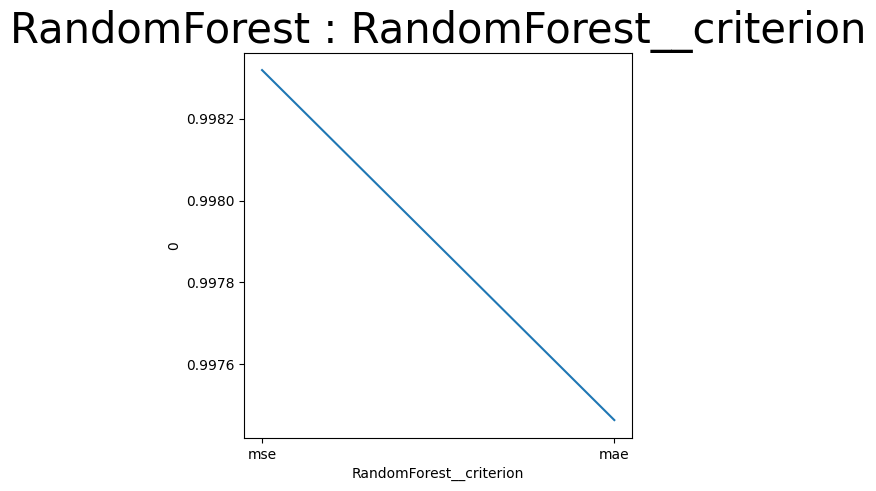

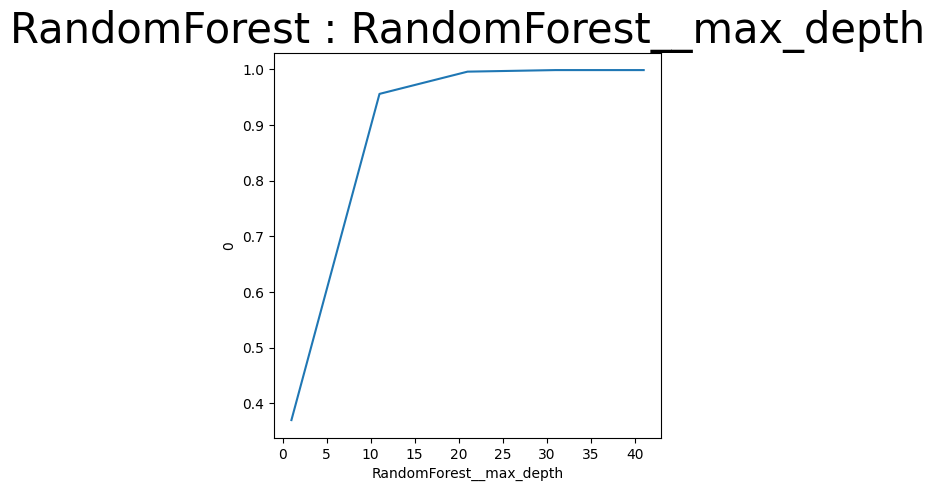

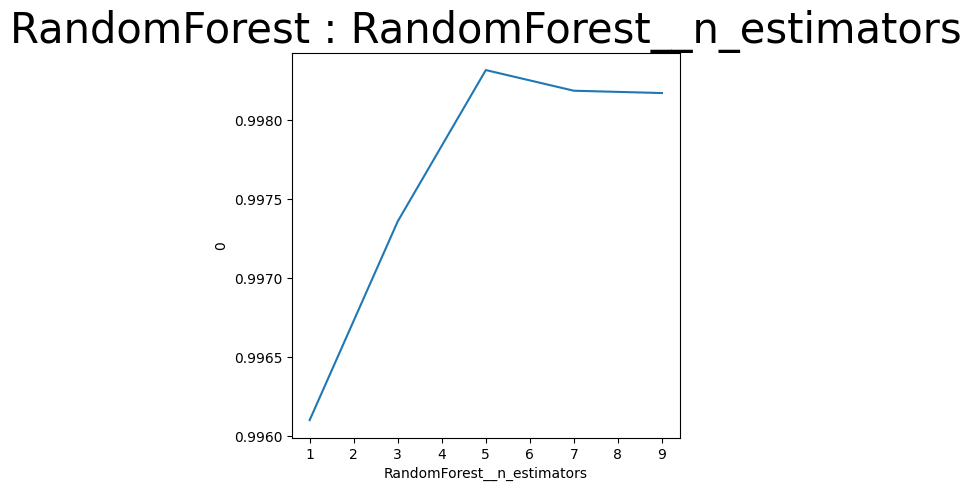

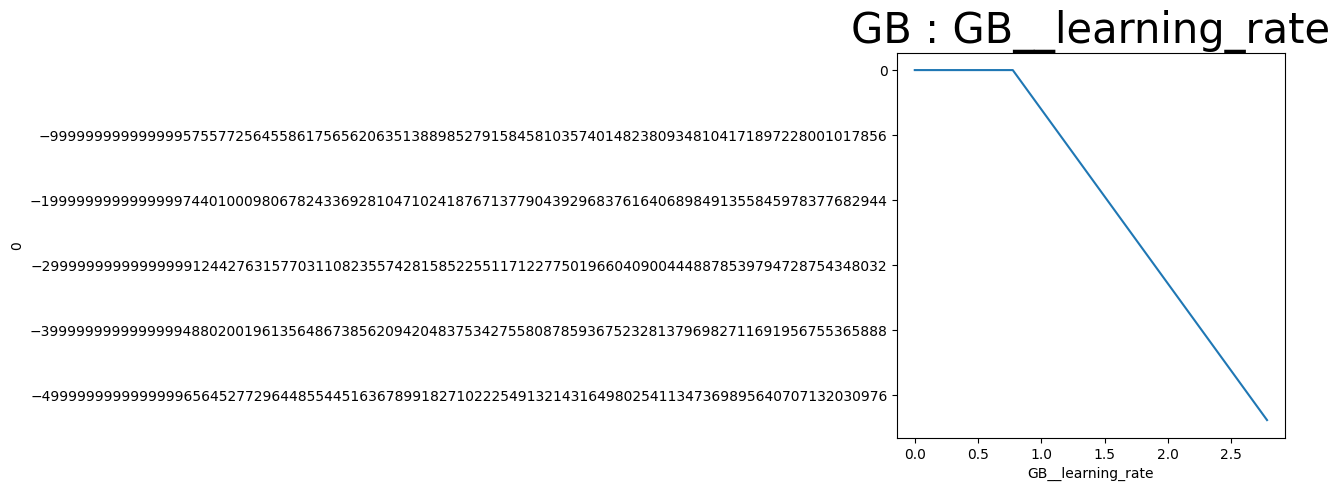

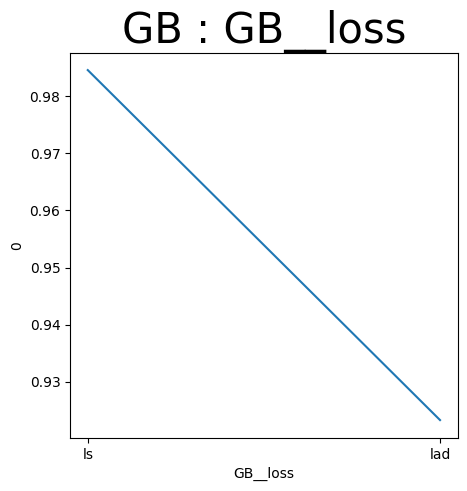

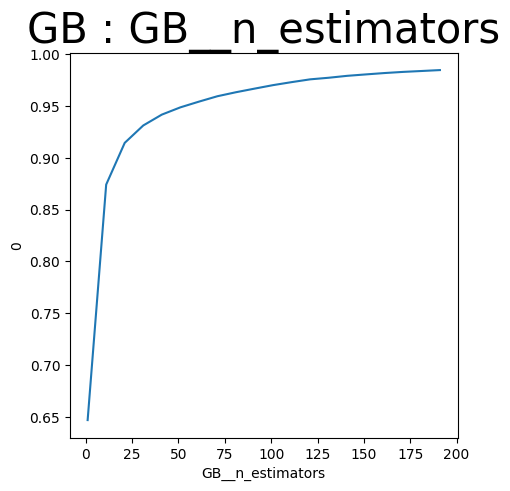

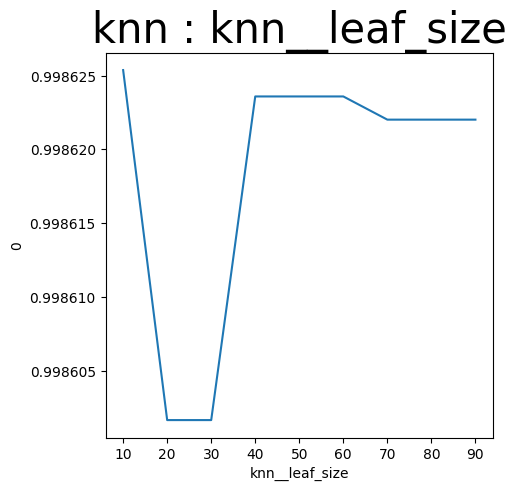

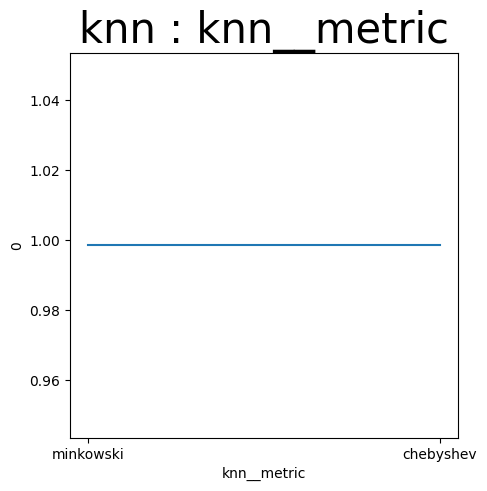

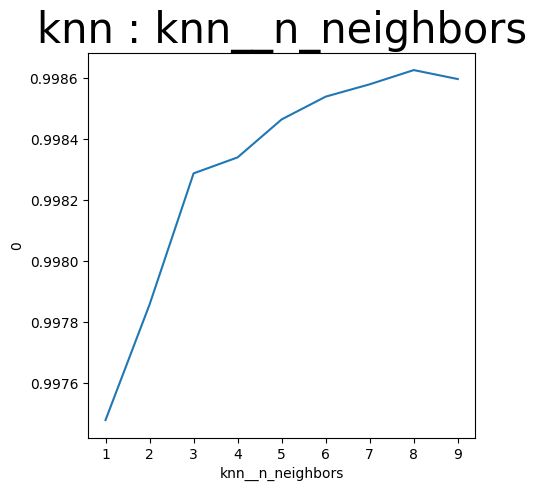

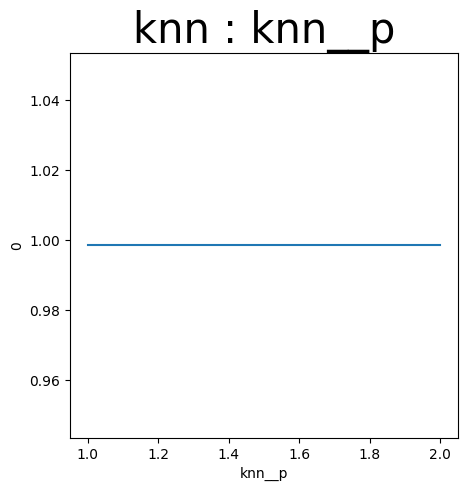

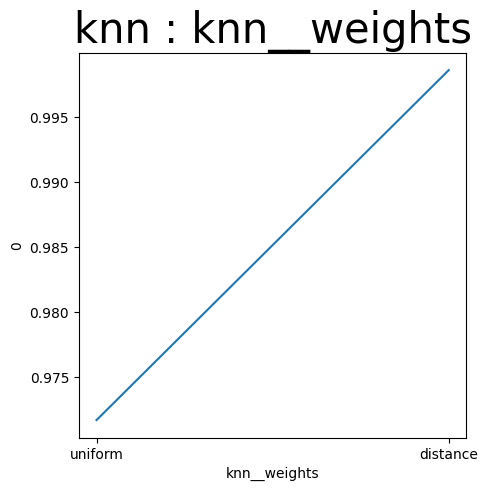

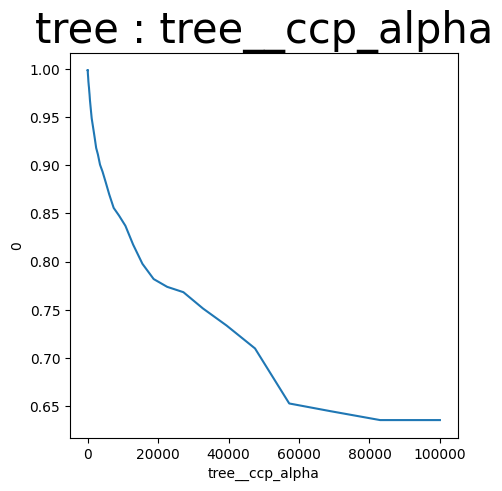

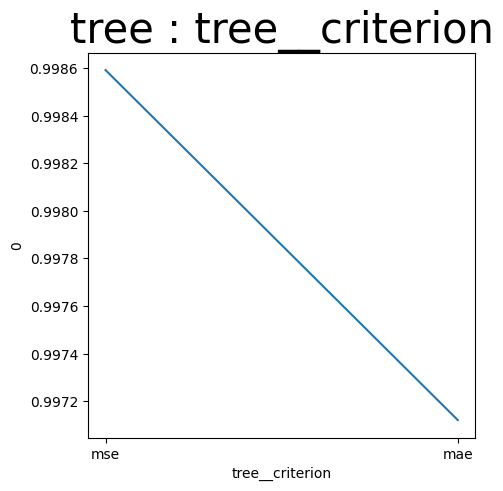

/var/folders/k7/ndqk_8r17ydgb7r37f2gd1pr0000gt/T/ipykernel_69051/1275769396.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data = experiment_results[m][(experiment_results[m][params]==[model_bestParams[m][i] for i in params]).all(axis=1)]


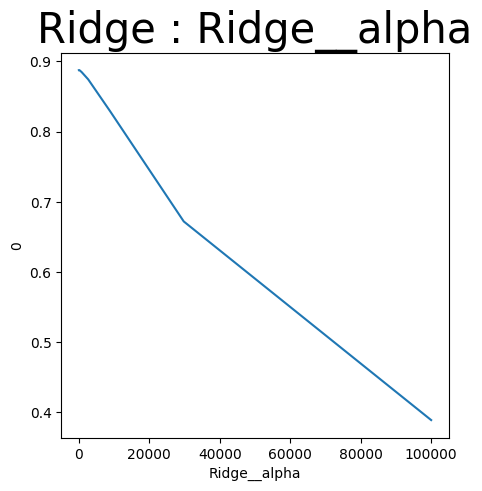

/var/folders/k7/ndqk_8r17ydgb7r37f2gd1pr0000gt/T/ipykernel_69051/1275769396.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data = experiment_results[m][(experiment_results[m][params]==[model_bestParams[m][i] for i in params]).all(axis=1)]


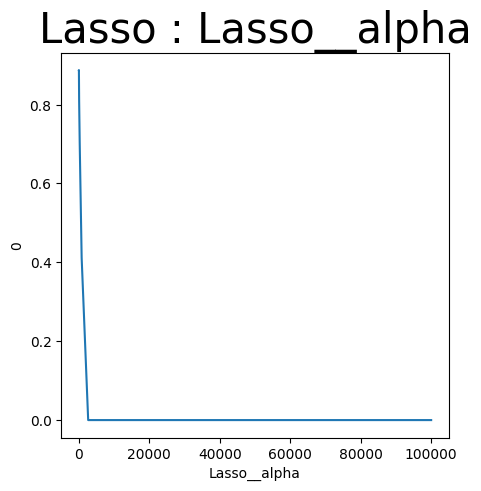

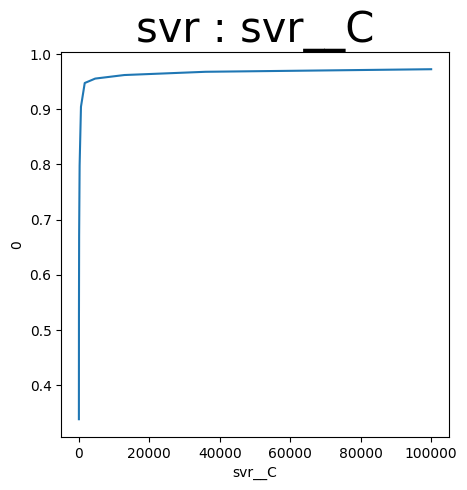

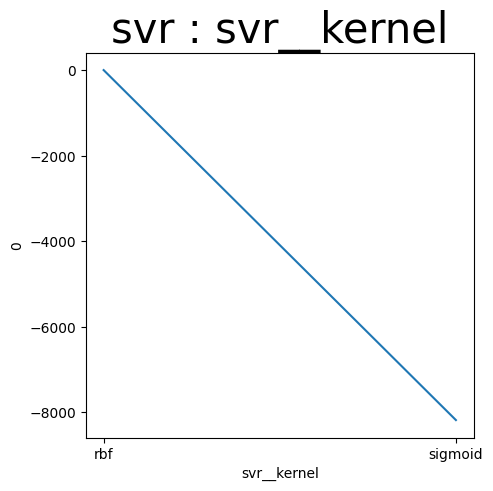

In [69]:
# Shows how changing the hyperparameter impacts the model.
for m in model_bestParams:
    for p in model_bestParams[m]:
        params = list(model_bestParams[m].keys())
        params.remove(p)
        plt.figure(figsize=(5,5))
        plt.title(f"{m} : {p}",fontsize=30)
        data = experiment_results[m][(experiment_results[m][params]==[model_bestParams[m][i] for i in params]).all(axis=1)]
        plt.ticklabel_format(useOffset=False, style='plain')
        sns.lineplot(x=data[p],y=data[0])
        plt.show()
